In [4]:
import sys
sys.path.append("../")
sys.path.append("../../")

from scripts.neutMakeJson import main as MakeNeutJson
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas

Welcome to JupyROOT 6.27/01


In [5]:
ROOT.rand = ROOT.TRandom3()

def poisson(x, mean):
    """
    ensure that mean is some int
    """
    assert isinstance(mean, int), "can only have integer mean values"
    x = int(x) # poisson only makes sense for int args
    return ROOT.TMath.Poisson(x,mean)

def gamma(x, mean):
    return 1 - ROOT.TMath.Gamma(x, mean)

def uniform():
    return ROOT.rand.Uniform()

def randomPoisson(mean, nSamples):
    """
    randomly sample the poisson to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    samples = [ROOT.rand.Poisson(mean) for i in range(nSamples)]
    return samples

def randomErlang(mean, nEvts, nSamples):
    """
    randomly sample the gamma to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    def erlang():
        return -1 * np.sum([ROOT.TMath.Log(ROOT.rand.Uniform()) for i in range(nEvts)]) / mean
    samples = [erlang() for i in range(nSamples)]
    return samples

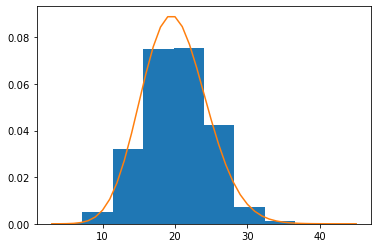

In [6]:
mean, nSamples = 20, int(3e5)
samples = randomPoisson(mean, nSamples)
a = plt.hist(samples, density=True)
x = np.arange(int(np.min(a[1])), int(np.max(a[1]))+1)
p1 = [poisson(i, mean) for i in x]
plt.plot(x,p1)

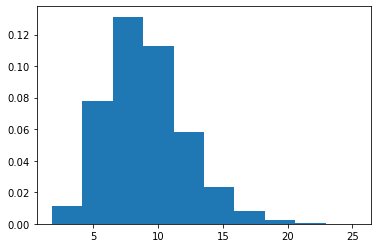

In [7]:
mean, nEvts, nSamples = 1, 9, int(1e4)
samples = randomErlang(mean, nEvts, nSamples)
a = plt.hist(samples, density=True)

In [8]:
print(type(ROOT.rand), type(ROOT.TRandom()))

<class cppyy.gbl.TRandom3 at 0x55731aed26c0> <class cppyy.gbl.TRandom at 0x55731df84400>


In [9]:
import numpy as np

def printArr(x):
    for i, row in enumerate(x):
        print(f"{i} - ", end="")
        for j, d in enumerate(row):
            print(f"({d:.0f})", end="")
        print()

def route(x, r=0, type="snake"):
    """
    args: r is the row position of the daq-node
    """
    assert all(isinstance(row, (list, np.ndarray)) for row in x), f"{x} not a matrix"
    row_size = len(x)
    col_size = len(x[0])
    assert all(len(ele) == col_size for ele in x), f"col sizes different in {x}"
    
    # parameterize this for general di location
    # edge = 
    
    def makeSnake(x):
        # snake if DAQ on left
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if not(i%2 == 0) and j == col_size-1:
                    x[i][j] = 1
                elif i%2 == 0:
                    if j == 0 and not(i == 0):
                        x[i][j] = 1
                    else:
                        x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    def makeTrunk(x, r):
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if j == r:
                    x[i][j] = 1
                elif j < r:
                    x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    if type=="snake":
        return makeSnake(x)
    elif type=="trunk":
        return makeTrunk(x, r)
    else:
        print("unrecognized type")
        return None

        
x = np.zeros((8,8))

print("snake")
printArr(route(x))
print("trunk")
printArr(route(x, r=2,type="trunk"))

snake
0 - (3)(3)(3)(3)(3)(3)(3)(3)
1 - (2)(2)(2)(2)(2)(2)(2)(1)
2 - (1)(3)(3)(3)(3)(3)(3)(3)
3 - (2)(2)(2)(2)(2)(2)(2)(1)
4 - (1)(3)(3)(3)(3)(3)(3)(3)
5 - (2)(2)(2)(2)(2)(2)(2)(1)
6 - (1)(3)(3)(3)(3)(3)(3)(3)
7 - (2)(2)(2)(2)(2)(2)(2)(1)
trunk
0 - (3)(3)(1)(2)(2)(2)(2)(2)
1 - (3)(3)(1)(2)(2)(2)(2)(2)
2 - (3)(3)(1)(2)(2)(2)(2)(2)
3 - (3)(3)(1)(2)(2)(2)(2)(2)
4 - (3)(3)(1)(2)(2)(2)(2)(2)
5 - (3)(3)(1)(2)(2)(2)(2)(2)
6 - (3)(3)(1)(2)(2)(2)(2)(2)
7 - (3)(3)(1)(2)(2)(2)(2)(2)


In [11]:
import pandas as pd
df = pd.read_feather("../../scripts/neutMP60k_lowFrq.feather")
# print(df.head)
arch = pd.unique(df['Architecture'])
print(arch)

['Push']


In [105]:
import ROOT


df['size'] = df['AsicX'].map(len)
snake_df = df[(df["Route"] == "snake") & (df["size"] == 16)]
print(snake_df.columns.tolist())

['Architecture', 'Route', 'Injected Hits', 'Injected Size', 'AsicX', 'AsicY', 'Frq', 'Start Time', 'Rel Time', 'Rel Tick', 'Local Hits', 'Local Max', 'Local Remain', 'Max Local', 'Remote Transactions', 'Remote Max', 'Remote Remain', 'Max Remote', 'DaqAsicX', 'DaqAsicY', 'DaqWordType', 'DaqTime', 'DaqTimestamp', 'DaqSimTime', 'Daqchannels', 'size']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


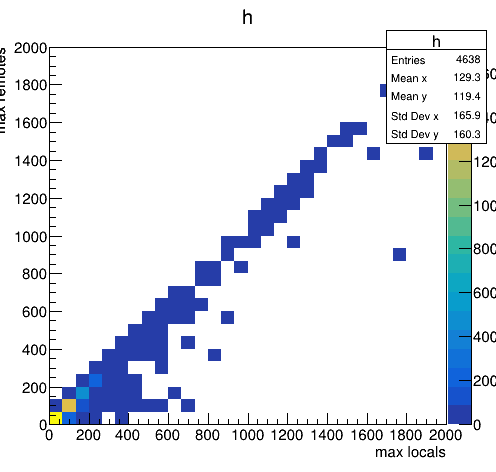

In [111]:
# snake_df.plot(x="Max Local", y="Max Remote")

m_locals = np.array(snake_df["Max Local"])
m_remotes = np.array(snake_df["Max Remote"])

c = ROOT.TCanvas("c", "c", 500, 500)
th2 = ROOT.TH2D("h", "h", 30, 0, 2000, 30, 0, 2000)

for i in range(len(m_locals)):
    th2.Fill(m_locals[i], m_remotes[i])

th2.Draw("colz")
th2.GetXaxis().SetTitle("max locals")
th2.GetYaxis().SetTitle("max remotes")
c.Draw()

(array([1220.,  367.,  628.,  392.,  569.,  334.,  584.,  182.,  102.,
         260.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

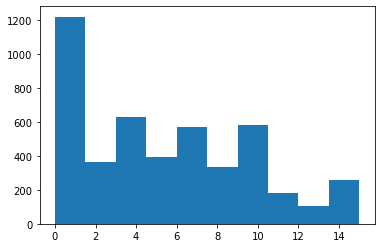

In [96]:
maxIndex = np.array(snake_df["Remote Max"].map(np.argmax))
plt.hist(maxIndex)

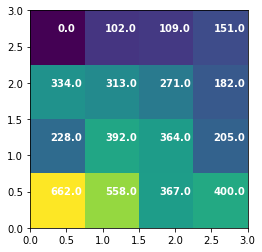

In [66]:
import matplotlib.pyplot as plt

ax = np.stack(np.array(snake_df["AsicX"]))
ay = np.stack(np.array(snake_df["AsicY"]))

max_ax = [ ax[i, maxIndex[i]] for i in range(len(maxIndex)) ]
max_ay = [ ay[i, maxIndex[i]] for i in range(len(maxIndex)) ]

fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = ax.hist2d(max_ax, max_ay, bins=(4,4))

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, hist.T[i,j], 
                color="w", ha="center", va="center", fontweight="bold")

[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3] [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3] 30350726.0
getting ax


(<matplotlib.image.AxesImage at 0x7f982c69a610>,
 <matplotlib.colorbar.Colorbar at 0x7f982c69ac10>)

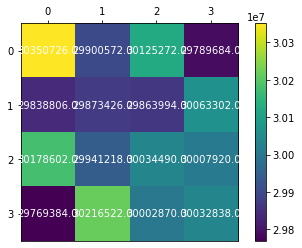

In [94]:
from QpixAsicArray import heatMap

ax = np.array(snake_df["AsicX"])[0]
ay = np.array(snake_df["AsicY"])[0]
afrqs = np.array(snake_df["Frq"])[0]

print(ax, ay, afrqs[0])

frqs = np.zeros((4,4))
for i in range(len(ax)):
        frqs[int(i/4)][i%4] = afrqs[i]

heatMap(frqs, 4, 4)